In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
df = pd.read_csv("data/TXF1-Tick-Trade.txt")
# df = pd.read_csv("data/TXF1-KWAY64V2-TAIFEX-Futures-Minute-Trade.txt")
print(df.shape)
df.head()

(1529491, 5)


,Symbol,Date,Time,Price,Volume
0,TXF1,2022/11/28,08:45:00,14550.0,561
1,TXF1,2022/11/28,08:45:00,14551.0,1
2,TXF1,2022/11/28,08:45:00,14553.0,1
3,TXF1,2022/11/28,08:45:00,14554.0,1
4,TXF1,2022/11/28,08:45:00,14555.0,3


<AxesSubplot: xlabel='Time'>

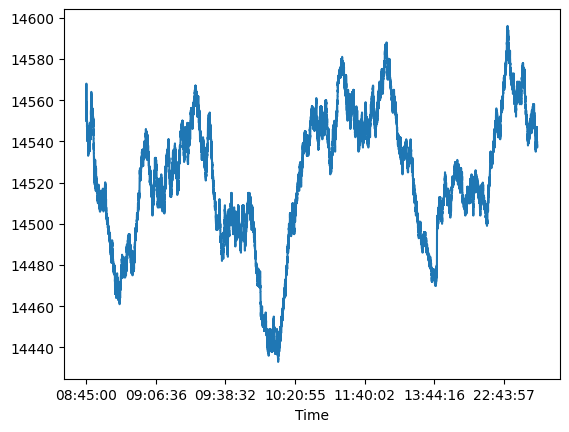

In [3]:
df.query("Date == '2022/11/28'").set_index("Time")["Price"].plot()

In [4]:
df.insert(1, "time", df["Date"] + " " + df["Time"])
df["time"] = pd.to_datetime(df["time"])

In [5]:
df["Time"] = df["Time"].str.replace(":", "").str[:-2]
df["Day_night"] = df.eval("(Time >= '0845') & (Time <= '1345')")
df = df[df["Day_night"]].reset_index(drop = True)
df["Price"] = df["Price"].astype(int)
print(df.shape)
df.head()

(904297, 7)


,Symbol,time,Date,Time,Price,Volume,Day_night
0,TXF1,2022-11-28 08:45:00,2022/11/28,0845,14550,561,True
1,TXF1,2022-11-28 08:45:00,2022/11/28,0845,14551,1,True
2,TXF1,2022-11-28 08:45:00,2022/11/28,0845,14553,1,True
3,TXF1,2022-11-28 08:45:00,2022/11/28,0845,14554,1,True
4,TXF1,2022-11-28 08:45:00,2022/11/28,0845,14555,3,True


df["year"] = df["date"].dt.year
df1 = df.groupby(["year", "Time"])["TotalVolume"].agg(["mean", "sum"])

des_all = df["TotalVolume"].describe(percentiles = np.arange(0.7, 0.99, .01))
des_all = pd.DataFrame(des_all).loc["70%":]

df_20 = df.query("year >= 2020")
des_20 = df_20["TotalVolume"].describe(percentiles = np.arange(0.7, 0.99, .01))
des_20 = pd.DataFrame(des_20).loc["70%":]

df_rm_oc = df.query("(Time > '0846') & (Time < '1345')")
des_rm_oc = df_rm_oc["TotalVolume"].describe(percentiles = np.arange(0.7, 0.99, .01))
des_rm_oc = pd.DataFrame(des_rm_oc).loc["70%":]

df_20_rm_oc = df.query("(Time > '0846') & (Time < '1345') & (year >= 2020)")
des_20_rm_oc = df_20_rm_oc["TotalVolume"].describe(percentiles = np.arange(0.7, 0.99, .01))
des_20_rm_oc = pd.DataFrame(des_20_rm_oc).loc["70%":]

des = pd.concat([des_all, des_20, des_rm_oc, des_20_rm_oc], axis = 1)
des.columns = ["all", "2020_2022", "remove_O_C", "2020_2022_remove_O_C"]

with pd.ExcelWriter("data/per_min.xlsx") as writer: 
    des.to_excel(writer, sheet_name = "分位數")
    df1.to_excel(writer, sheet_name = "mean_sum")

In [6]:
df = df.groupby("time").agg({"Price": ["first", "max", "min", "last"], "Volume": "sum"})
df.columns = ["open", "high", "low", "close", "volume"]
df = df.reset_index()
df = df.sort_values("time").reset_index(drop = True)
df

,time,open,high,low,close,volume
0,2022-11-28 08:45:00,14550,14568,14533,14533,1208
1,2022-11-28 08:45:01,14537,14541,14533,14535,237
2,2022-11-28 08:45:02,14538,14542,14535,14540,129
3,2022-11-28 08:45:03,14539,14549,14539,14545,98
4,2022-11-28 08:45:04,14547,14548,14543,14543,94
...,...,...,...,...,...,...
262480,2022-12-29 09:20:02,13981,13985,13981,13984,22
262481,2022-12-29 09:20:03,13985,13986,13984,13984,11
262482,2022-12-29 09:20:04,13986,13986,13986,13986,3
262483,2022-12-29 09:20:05,13986,13987,13986,13987,4


df.to_excel("data/TICKS_day_min.xlsx", index = False)

In [7]:
df["vol_100"] = (df["volume"] > 100).astype(int)
print(df.shape)
df.head()

(262485, 7)


,time,open,high,low,close,volume,vol_100
0,2022-11-28 08:45:00,14550,14568,14533,14533,1208,1
1,2022-11-28 08:45:01,14537,14541,14533,14535,237,1
2,2022-11-28 08:45:02,14538,14542,14535,14540,129,1
3,2022-11-28 08:45:03,14539,14549,14539,14545,98,0
4,2022-11-28 08:45:04,14547,14548,14543,14543,94,0


In [8]:
period = 10
for i in tqdm(range(len(df))):
    if df.loc[i, "vol_100"] == 1:
        df.loc[i+1:i+period, "prev_time"] =  df.loc[i, "time"]
        df.loc[i+1:i+period, "prev_high"] = df.loc[i, "high"]
        df.loc[i+1:i+period, "prev_low"] = df.loc[i, "low"]

100%|██████████| 262485/262485 [00:01<00:00, 154096.23it/s]


In [9]:
df["break_high"] = df.eval("high > prev_high").astype(int)
df["break_low"] = df.eval("low < prev_low").astype(int)

In [10]:
for i in tqdm(range(len(df))):
    if (df.loc[i, "break_high"] == 1) & (df.loc[i, "break_low"] == 0):
        df.loc[i, "direction"] = "long"
        
    elif  (df.loc[i, "break_high"] == 0) & (df.loc[i, "break_low"] == 1):
        df.loc[i, "direction"] = "short"

100%|██████████| 262485/262485 [00:05<00:00, 46942.10it/s]


In [11]:
hold = 0
slippage = 2
fee = 2

adjust_cost = slippage + fee
df[["hold", "long", "short", "cost", "profit", "loss", "win", "net"]] = 0

for i in tqdm(range(1, len(df))):
    if (hold == 1):
            if df.loc[i-1, "long"] == 1:
                df.loc[i, "hold"] = hold
                df.loc[i, "long"] = 1
                df.loc[i, "cost"] = df.loc[i-1, "cost"]

                df.loc[i, "profit"] = max(df.loc[i, "high"] - df.loc[i, "cost"], 0)
                df.loc[i, "loss"] = max(df.loc[i, "cost"] - df.loc[i, "low"], 0)

            elif df.loc[i-1, "short"] == 1:
                df.loc[i, "hold"] = hold
                df.loc[i, "short"] = 1
                df.loc[i, "cost"] = df.loc[i-1, "cost"]

                df.loc[i, "profit"] = max(df.loc[i, "cost"] - df.loc[i, "low"], 0)
                df.loc[i, "loss"] = max(df.loc[i, "high"] - df.loc[i, "cost"], 0)
        
    else:         
        if df.loc[i, "direction"] == "long":
            hold = 1
            df.loc[i, "hold"] = hold
            df.loc[i, "long"] = 1
            df.loc[i, "cost"] = df.loc[i, "high"]
            
            df.loc[i, "profit"] = max(df.loc[i, "high"] - df.loc[i, "cost"], 0)
            df.loc[i, "loss"] = max(df.loc[i, "cost"] - df.loc[i, "low"], 0)
            
        elif df.loc[i, "direction"] == "short":
            hold = 1
            df.loc[i, "hold"] = hold
            df.loc[i, "short"] = 1
            df.loc[i, "cost"] = df.loc[i, "low"]
            
            df.loc[i, "profit"] = max(df.loc[i, "cost"] - df.loc[i, "low"], 0)
            df.loc[i, "loss"] = max(df.loc[i, "high"] - df.loc[i, "cost"], 0)
    


    if (df.loc[i, "profit"] >= 30):
        df.loc[i, "win"] = 1
        df.loc[i, "net"] = -30
        hold = 0
        
    elif  (df.loc[i, "loss"] >= 10):
        df.loc[i, "win"] = -1
        df.loc[i, "net"] = -10
        hold = 0

100%|██████████| 262484/262484 [00:54<00:00, 4807.17it/s] 


In [12]:
df.to_excel("data/strategy1.xlsx", index = False)

In [13]:
df.query("win == 1")

,time,open,high,low,close,volume,vol_100,prev_time,prev_high,prev_low,...,break_low,direction,hold,long,short,cost,profit,loss,win,net
427,2022-11-28 08:52:33,14489,14489,14487,14487,10,0,NaT,NaN,NaN,...,0,NaN,1,0,1,14517,30,0,1,-30
1049,2022-11-28 09:03:32,14531,14535,14531,14534,42,0,NaT,NaN,NaN,...,0,NaN,1,1,0,14505,30,0,1,-30
1905,2022-11-28 09:18:57,14540,14545,14540,14544,110,1,NaT,NaN,NaN,...,0,NaN,1,1,0,14513,32,0,1,-30
2781,2022-11-28 09:34:49,14518,14518,14515,14515,123,1,NaT,NaN,NaN,...,0,NaN,1,0,1,14547,32,0,1,-30
2912,2022-11-28 09:37:02,14485,14486,14482,14482,41,0,NaT,NaN,NaN,...,0,NaN,1,0,1,14514,32,0,1,-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252181,2022-12-28 09:40:02,14157,14157,14152,14155,173,1,NaT,NaN,NaN,...,0,NaN,1,0,1,14184,32,0,1,-30
255255,2022-12-28 10:58:01,14092,14092,14092,14092,22,0,NaT,NaN,NaN,...,0,NaN,1,0,1,14122,30,0,1,-30
260731,2022-12-29 08:45:00,13960,13970,13960,13970,667,1,NaT,NaN,NaN,...,0,NaN,1,0,1,14112,152,0,1,-30
261730,2022-12-29 09:06:01,13983,13985,13981,13982,42,0,NaT,NaN,NaN,...,0,NaN,1,0,1,14012,31,0,1,-30


In [14]:
df.query("win == -1")

,time,open,high,low,close,volume,vol_100,prev_time,prev_high,prev_low,...,break_low,direction,hold,long,short,cost,profit,loss,win,net
60,2022-11-28 08:46:00,14536,14536,14519,14519,401,1,NaT,NaN,NaN,...,0,NaN,1,1,0,14542,0,23,-1,-10
61,2022-11-28 08:46:01,14523,14531,14518,14522,207,1,2022-11-28 08:46:00,14536.0,14519.0,...,1,short,1,0,1,14518,0,13,-1,-10
65,2022-11-28 08:46:05,14526,14527,14522,14522,35,0,2022-11-28 08:46:01,14531.0,14518.0,...,0,NaN,1,0,1,14516,0,11,-1,-10
485,2022-11-28 08:53:34,14483,14483,14482,14482,25,0,NaT,NaN,NaN,...,0,NaN,1,1,0,14492,0,10,-1,-10
852,2022-11-28 09:00:13,14483,14489,14483,14486,85,0,2022-11-28 09:00:07,14481.0,14477.0,...,0,long,1,0,1,14478,0,11,-1,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260736,2022-12-29 08:45:05,13972,13974,13966,13971,92,0,2022-12-29 08:45:00,13970.0,13960.0,...,0,long,1,1,0,13976,0,10,-1,-10
260750,2022-12-29 08:45:19,13966,13966,13962,13964,54,0,NaT,NaN,NaN,...,0,NaN,1,1,0,13972,0,10,-1,-10
261475,2022-12-29 09:01:23,14007,14010,14007,14010,83,0,NaT,NaN,NaN,...,0,NaN,1,0,1,13999,0,11,-1,-10
261572,2022-12-29 09:03:05,14018,14018,14013,14014,123,1,NaT,NaN,NaN,...,0,NaN,1,1,0,14023,0,10,-1,-10


In [15]:
df.iloc[1:61]

,time,open,high,low,close,volume,vol_100,prev_time,prev_high,prev_low,...,break_low,direction,hold,long,short,cost,profit,loss,win,net
1,2022-11-28 08:45:01,14537,14541,14533,14535,237,1,2022-11-28 08:45:00,14568.0,14533.0,...,0,NaN,0,0,0,0,0,0,0,0
2,2022-11-28 08:45:02,14538,14542,14535,14540,129,1,2022-11-28 08:45:01,14541.0,14533.0,...,0,long,1,1,0,14542,0,7,0,0
3,2022-11-28 08:45:03,14539,14549,14539,14545,98,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,7,3,0,0
4,2022-11-28 08:45:04,14547,14548,14543,14543,94,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,6,0,0,0
5,2022-11-28 08:45:05,14545,14546,14543,14545,16,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,4,0,0,0
6,2022-11-28 08:45:06,14543,14544,14541,14541,21,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,2,1,0,0
7,2022-11-28 08:45:07,14542,14545,14541,14542,43,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,3,1,0,0
8,2022-11-28 08:45:08,14544,14547,14541,14546,48,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,5,1,0,0
9,2022-11-28 08:45:09,14546,14550,14544,14550,44,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,8,0,0,0
10,2022-11-28 08:45:10,14550,14556,14550,14556,19,0,2022-11-28 08:45:02,14542.0,14535.0,...,0,long,1,1,0,14542,14,0,0,0
